# Merged notebook containing code and learnings from cxr project
This notebook is meant as a starting point for the master thesis neural net. Ideas, learnings and code from previous notebooks is gathered and described, to summarize the current status of the project.

## General components that can be kept
*1. Preamble*<br>
Imort of packages<br>
Configuration variables like file paths, boolean switches, numeric settings, etc.

*2. Getting the data*<br>
Funciton definitions<br>
*CHANGES NECESSARY* Read meta data + image files and convert it to a dataframe<br>
*CHANGES NECESSARY* Unify labling of datasets<br>
Train / Test / Val split<br>
Shuffling data

*3. Data preprocessing*<br>
Image augmentation<br>
Data generator class<br>

*4. Model training*<br>
**TODO: Think about a concept for comparing the nets**<br>
Define neural net architecture<br>
Model settings like learning rate reduction, early stopping, model save setting<br>
Training the model

*5. Model evaluation*<br>
Check performance parameters like:
- accuracy
- loss
- recall
- f1

Evaluate generalizability on validation data<br>
Show confusion matrix

# 1. Preamble

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
import pandas as pd
import math
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from pathlib import Path
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, AveragePooling2D, Conv2D, MaxPool2D, Activation, GlobalAveragePooling2D, Lambda
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split

In [3]:
# Config
IMG_SIZE = 256
BATCH_SIZE=32
CHANNELS=1
USE_MASKS=False
TRANSFER_LEARNING=False
DEBUG_AND_TEST_MODE=False

MODELSAVE = "models/custom_model_kermany"

if(USE_MASKS):
    MODELSAVE += "_w_masks.h5"
else:
    MODELSAVE += "_wo_masks.h5"

pd.set_option('display.max_colwidth', None)

DATASET_SOURCE = 1
USE_AWS = False
if USE_AWS:
    DATSET_SOURCE = 2
    
base_path = ''

if DATASET_SOURCE == 0:      # local
    base_path = '/mnt/f/DatasetsChestXRay/'
elif DATASET_SOURCE == 1:    # oth amberg
    base_path = '/home/9424/NAVARA/masterarbeit/datasets/'
elif DATASET_SOURCE == 2:    # aws
    base_path = ''

datasets = {
    #'padchest': 'BIMCV-PadChest/',
    #'cxr14': 'ChestX-ray14_NationalInstituesofHealthClinicalCenter/',
    #'chexpert': 'CheXpert/',
    'kermany': 'KermanyChildStudy/',
    #'mimic': 'MIMIC-CXR/',
    #'openi': 'Open-i_IndianaUniversityNetworkforPatientCare/'
}

## Dataset parent class
A class that is suitable for creating a combined dataset consisting of different original datasets

In [4]:
class dataset:
    def __init__(self, dataset_dict=None):
        self.df = None
        self.train = None
        self.test = None
        
        first = True
        if dataset_dict is not None:
            for dataset_name, dataset in dataset_dict.items():
                if first:
                    first = False
                    self.df = dataset.df
                else:
                    self.df = pd.concat([self.df, dataset.df], ignore_index=True)

    def train_test_split(self, test_size=0.2):
        self.train, self.test = train_test_split(self.df, test_size=test_size)
    
    def stratified_train_test_split(self, test_size=0.2, stratify_column='dataset'):
        self.train, self.test = train_test_split(self.df,
                                                 test_size=test_size,
                                                 stratify=None if stratify_column is None else self.df[stratify_column])

    def shuffle(self):
        self.df = self.df.sample(frac=1).reset_index(drop=True)
        
    def shuffle_all(self):
        self.df = self.df.sample(frac=1).reset_index(drop=True)
        if self.train is not None:
            self.train = self.train.sample(frac=1).reset_index(drop=True)
        else:
            print("Can't shuffle training data (emtpy)")
        if self.test is not None:
            self.test = self.test.sample(frac=1).reset_index(drop=True)
        else:
            print("Can't shuffle test data (empty)")

## Dataset child class
A class that is used to retrieve data from the original datasets

In [5]:
class original_dataset(dataset):
    def __init__(self, name, folder):
        super().__init__()
        self.name = name
        self.folder = folder
        self.path = base_path + self.folder
        self.df = self.create_dataset()

    def create_dataset(self):
        # initialize dataframe
        data = {}
        i = 0
        # iterate over folders and files
        for label_folder in ['normal/', 'pneumonia/']:
            for filename in os.listdir(self.path + label_folder):
                img_path = self.path + label_folder + str(filename)
                label_pneumonia = 0
                if label_folder == 'pneumonia/':
                    label_pneumonia = 1
                data[i] = {'img': img_path, 'dataset': self.name, 'label_pneumonia': label_pneumonia, 'label_viral': None, 'label_covid': None}
                i = i + 1

        print("Successfully created " + self.name + " dataset")
        return pd.DataFrame.from_dict(data, "index")


# 2. Load Data

In [6]:
# dictionary of all datasets
dataset_dict = {}

# load all datasets and execute a train test split
for dataset_name, folder_name in datasets.items():
    tmp_dataset = original_dataset(dataset_name, folder_name)
    #tmp_dataset.train_test_split()
    #tmp_dataset.shuffle()
    dataset_dict[dataset_name] = tmp_dataset

Successfully created kermany dataset


In [7]:
if DEBUG_AND_TEST_MODE:
    kermany_dataset = original_dataset('kermany', 'KermanyChildStudy/')
    kermany_dataset.shuffle()
    kermany_dataset.train_test_split()

In [8]:
# teilmenge für schnelle tests verwenden
#dataset_dict['chexpert'].df = dataset_dict['chexpert'].df.head(500)
#dataset_dict['mimic'].df = dataset_dict['mimic'].df.head(500)

combined_dataset = dataset(dataset_dict)
combined_dataset.shuffle()
combined_dataset.train_test_split()


In [9]:
combined_dataset.df.head()

,img,dataset,label_pneumonia,label_viral,label_covid
0,/home/9424/NAVARA/masterarbeit/datasets/KermanyChildStudy/pneumonia/person1325_bacteria_3366.jpeg,kermany,1,None,None
1,/home/9424/NAVARA/masterarbeit/datasets/KermanyChildStudy/normal/IM-0618-0001-0002.jpeg,kermany,0,None,None
2,/home/9424/NAVARA/masterarbeit/datasets/KermanyChildStudy/normal/IM-0761-0001.jpeg,kermany,0,None,None
3,/home/9424/NAVARA/masterarbeit/datasets/KermanyChildStudy/pneumonia/person67_bacteria_332.jpeg,kermany,1,None,None
4,/home/9424/NAVARA/masterarbeit/datasets/KermanyChildStudy/pneumonia/person1522_virus_2651.jpeg,kermany,1,None,None


In [10]:
len(combined_dataset.df)

5856

# 3. Data Preprocessing

## Image Augmentation

In [11]:
import imgaug.augmenters as iaa
aug = iaa.AllChannelsCLAHE(clip_limit=(0.05))

In [12]:
def applySigmoidContrast(img):
    img = aug.augment_image(img)
    return img

In [13]:
import imgaug as ia
import imgaug.augmenters as iaa

sometimes = lambda aug: iaa.Sometimes(0.5, aug)
sometimes25 = lambda aug: iaa.Sometimes(0.25, aug)

seq_img = iaa.Sequential([
    # sometimes(iaa.SigmoidContrast(gain=(3, 10), cutoff=(0.4, 0.6))),
    sometimes(iaa.Affine(
            rotate=(-10, 10),
            shear=(-10,10),
            scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}
    )),
    sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.15))),
], random_order=True)

## Data Generator class

In [14]:
if DEBUG_AND_TEST_MODE:
    # just testing some stuff
    path = dataset_dict['mimic'].df.iloc[0].img
    img = cv2.resize(cv2.imread(str(path), cv2.IMREAD_GRAYSCALE), (IMG_SIZE, IMG_SIZE))
    #img = img.reshape(img.shape[0], img.shape[1])
    print(np.shape(img))
    rgb = np.repeat(img[..., np.newaxis], 3, -1)
    print(np.shape(rgb))
    seq_img_i = seq_img.to_deterministic()   
    img = seq_img_i.augment_image(img)
    plt.imshow(img, cmap='gray')

In [15]:
if DEBUG_AND_TEST_MODE:
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
    
    ax1.imshow(rgb[:,:,0], cmap='gray')
    ax2.imshow(rgb[:,:,1], cmap='gray')
    ax3.imshow(rgb[:,:,2], cmap='gray')

In [16]:
class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, df, augment, img_size, batch_size=8, shuffle=True, useMasks=True):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.shuffle = shuffle
        self.augment = augment
        self.img_size = img_size
        self.useMasks = useMasks
        self.error_count = 0

    def __len__(self):
        return math.ceil(len(self.indices)/ self.batch_size)

    def __getitem__(self, index):
        indexes = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in indexes]
        X, y = self.__get_data(batch)
        return np.array(X), np.array(y)

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __get_data(self, batch):
        X_img_paths = self.df['img']
        # X_mask_paths = self.df['mask']
        X_imgs = []
        # X_masks = []
        Y = self.df['label_pneumonia'].iloc[batch].to_numpy()

        for i in range(0, len(batch)):
            try:
                # read image as grayscale and resize it
                img = cv2.resize(cv2.imread(str(X_img_paths.iloc[batch[i]]), cv2.IMREAD_GRAYSCALE), (self.img_size, self.img_size))
                # reshape image
                if not TRANSFER_LEARNING:
                    img = img.reshape(img.shape[0], img.shape[1],1)
            except Exception as e:
                self.error_count = self.error_count + 1
                print('ERROR during cv2.resize, image was: ' + str(X_img_paths.iloc[batch[i]]))
                print(str(e))
            
            if not self.useMasks:
                if(self.augment is True):
                    seq_img_i = seq_img.to_deterministic()   
                    img = seq_img_i.augment_image(img)
                # else img remains untouched
            else:
                try:
                    mask = cv2.imread(str(X_mask_paths.iloc[batch[i]]), cv2.IMREAD_GRAYSCALE)
                    #mask = cv2.resize(mask, (self.img_size, self.img_size))
                    mask = cv2.threshold(mask,0,1,cv2.THRESH_BINARY)[1]
                except Exception as e:
                    self.error_count = self.error_count + 1
                    print(str(e))
                # Multiply binarized mask on grayscaled version of the x-ray. 
                # So only the lung will remain, everything else will be set to 0
                try:
                    mask = mask.reshape(IMG_SIZE,IMG_SIZE,1)
                except:
                    self.error_count = self.error_count + 1
                    print("i", i)
                    print(str(X_mask_paths.iloc[batch[i]]))
                cutout_img = img * mask
                cutout_img = cutout_img.reshape(IMG_SIZE,IMG_SIZE,1)

                if(self.augment is True):
                    seq_img_i = seq_img.to_deterministic()   
                    img = seq_img_i.augment_image(img) #### img
                    cutout_img = seq_img_i.augment_image(cutout_img) #### cutout

                img = np.dstack([img, cutout_img])
                mask = mask / 255.0

            # normalize
            img = img / 255.0
            # reshape grayscale image to match rgb image shape for transfer learning
            if TRANSFER_LEARNING:
                img = np.repeat(img[..., np.newaxis], 3, -1)
            X_imgs.append(img)

        return X_imgs, Y

# 4. Model Training

In [17]:
def get_custom_model():
    model = Sequential()
    # Conv block1 = cb0
    model.add(Conv2D(3, (1,1), padding="same",activation="relu", input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS)))
    model.add(Conv2D(32, (3,3), padding = "same", activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS), name="cb0_conv0"))
    model.add(Conv2D(32, (3,3), padding = "same", activation='relu', name="cb0_conv1"))
    model.add(MaxPool2D(pool_size = (3, 3), name="cb0_maxpool"))
    model.add(Dropout(0.2, name="cb0_dropout"))

    # Conv block2 = cb1
    model.add(Conv2D(64, (3,3), padding = "same", activation='relu', name="cb1_conv0"))
    model.add(Conv2D(64, (5,5), strides=(2,2), padding = "same", activation='relu', name="cb1_conv1"))
    model.add(Conv2D(64, (3,3), padding = "same", activation='relu', name="cb1_conv2"))
    model.add(MaxPool2D(pool_size = (2, 2), name="cb1_maxpool"))
    model.add(Dropout(0.2, name="cb1_dropout"))

    # Dense block = db
    model.add(Flatten())
#     model.add(Dense(1024, activation='relu', name="db_dense1024"))
#     model.add(Dense(512, activation='relu', name="db_dense512"))
#     model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu', name="db_dense256"))
#     model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid', name="db_dense1"))

    model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [18]:
import keras
from classification_models.tfkeras import Classifiers

def get_resnet18():
    model = Sequential()
    
    ResNet18, preprocess_input = Classifiers.get('resnet18')
    
    n_classes = 1
    
    # build model
    model.add(ResNet18(input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet', include_top=False))
    model.add(Dropout(0.25))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='sigmoid'))

    model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    # freeze ResNet18
    model.layers[0].trainable = False
    
    model.summary()
    
    # add custom layers
    #pooling = keras.layers.GlobalAveragePooling2D()(base_model.output)
    #output = keras.layers.Dense(n_classes)(pooling)
    
    #model = keras.models.Model(inputs=[base_model.input], outputs=[output])
    
    #model.compile(optimizer=keras.optimizers.Adam(),
     #             loss=keras.losses.BinaryCrossentropy(from_logits=True),
      #            metrics=[keras.metrics.BinaryAccuracy()])
    return model

In [19]:
# K-Fold
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, accuracy_score

In [20]:
kf5 = StratifiedKFold(n_splits=5, shuffle=True)

In [21]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.8,
    patience=3,
    verbose=2, # verbose=1 results in a warning, use verbose=2 (bit less info) or verbose=0 (no info) instead
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
)

mcp_save = ModelCheckpoint(MODELSAVE, save_best_only=True, monitor='val_loss', mode='min')

In [22]:
df_train = combined_dataset.train

## Kermany verifikation / selbe ergebnisse reproduzieren

## (Hier wird gerade die custom Architektur von Daniel und Sebastian auf die Übertragbarkeit von Kermany nach CXR14 überpüft -> get_custom_model und gesamter cxr14 Datensatz)

In [23]:
%%time

import sys

# store original stdout to forward output back to the notebook afterwards
orig_stdout = sys.stdout
# create file to buffer keras messages
sys.stdout = open('keras_output.txt', 'a')

run = 1
val_scores = []
f1_scores = []
histories = []
best_f1_model = None
highestF1 = 0
EPOCHS = 12 # 12

strange_fold_train = None
strange_fold_val = None

# hier das .label_pneumonia ändern in die kombinierte Variable
for train_index, val_index in kf5.split(df_train, df_train.label_pneumonia):
    #print("Fold Nr.: ", run)
    df_fold_train = df_train.iloc[train_index]
    df_fold_val = df_train.iloc[val_index]

    df_fold_train.reset_index(drop=True, inplace=True)
    df_fold_val.reset_index(drop=True, inplace=True)
    
    if run == 4:
        strange_fold_train = df_fold_train
        strange_fold_val = df_fold_val
    
    # print('=== Train Data: ===')
    # print('Normal:', len(df_fold_train[df_fold_train['label'] == 0]))
    # print('Pneumonia:', len(df_fold_train[df_fold_train['label'] == 1]))
    # print('|---> Bacterial:', len(df_fold_train[df_fold_train['label2'] == 'bacteria']))
    # print('|---> Viral:', len(df_fold_train[df_fold_train['label2'] == 'virus']))
    # print('    |---> Covid:', len(df_fold_train[df_fold_train['label3'] == 'covid19']))
    
    # print('=== Val Data: ===')
    # print('Normal:', len(df_fold_val[df_fold_val['label'] == 0]))
    # print('Pneumonia:', len(df_fold_val[df_fold_val['label'] == 1]))
    # print('|---> Bacterial:', len(df_fold_val[df_fold_val['label2'] == 'bacteria']))
    # print('|---> Viral:', len(df_fold_val[df_fold_val['label2'] == 'virus']))
    # print('    |---> Covid:', len(df_fold_val[df_fold_val['label3'] == 'covid19']))
    
    train_generator = DataGenerator(df_fold_train, True, IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False, useMasks=USE_MASKS)
    val_generator = DataGenerator(df_fold_val, False, IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False, useMasks=USE_MASKS)
    

    # Adjust class_weights since we're dealing with imbalanced data here
    class_weights = class_weight.compute_class_weight('balanced', np.unique(df_fold_train['label_pneumonia']), df_fold_train['label_pneumonia'])
    class_weights = {0: class_weights[0], 1: class_weights[1]}
    #print("Class weights: ", class_weights)
    
    model = get_custom_model()
    #model = get_resnet18()
    
   

    history = model.fit(train_generator,
                    validation_data=val_generator,
                    validation_steps=len(val_generator),
                    steps_per_epoch=len(train_generator),
                    epochs=EPOCHS,
                    class_weight=class_weights,
                    callbacks=[mcp_save, learning_rate_reduction], #mcp_save, learning_rate_reduction]],
                    verbose = True)

    predictions = model.predict(val_generator)
    y_pred = (predictions > 0.5).astype('uint8')

    histories.append(history)

    f1 = f1_score(y_pred, df_fold_val.label_pneumonia)

    if(highestF1 == 0):
        highestF1 = f1
        best_f1_model = model
    else:
        if(f1 > highestF1):
            highestF1 = f1
            best_f1_model = model

    val_acc = accuracy_score(y_pred , df_fold_val.label_pneumonia)

    f1_scores.append(f1)
    val_scores.append(val_acc)
    
    run += 1

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1], y=0       0
1       1
2       1
3       1
4       1
       ..
3742    1
3743    1
3744    0
3745    1
3746    1
Name: label_pneumonia, Length: 3747, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1], y=0       0
1       1
2       1
3       1
4       1
       ..
3742    0
3743    1
3744    1
3745    1
3746    1
Name: label_pneumonia, Length: 3747, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1], y=0       0
1       1
2       1
3       1
4       1
       ..
3742    1
3743    0
3744    1
3745    1
3746    1
Name: label_pneumonia, Length: 3747, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass classes=[0 1], y=0       1
1       1
2     

In [24]:
np.array(f1_scores).mean()

0.9349951943451031

In [25]:
np.array(val_scores).mean()

0.8979585693566484

In [26]:
# set model to the best f1 model
model = best_f1_model

# 5. Model Evaluation

In [27]:
df_test = combined_dataset.test
df_test.reset_index(drop=True, inplace=True)

In [28]:
test_generator = DataGenerator(df_test, False, IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False, useMasks=USE_MASKS)

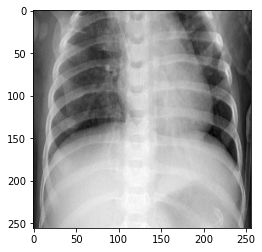

In [29]:
plt.imshow(test_generator.__getitem__(0)[0][0][:,:,0], cmap="gray")

In [30]:
results = model.evaluate(test_generator)
print("test loss, test acc:", results)

In [31]:
# print output in notebook instead of the file
sys.stdout = orig_stdout

In [32]:
print("Test pneumonia cases: ", len(df_test[df_test['label_pneumonia'] == 1]))
print("Test normal cases: ", len(df_test[df_test['label_pneumonia'] == 0]))

Test pneumonia cases:  856
Test normal cases:  316


In [33]:
predictions = model.predict(test_generator)

In [34]:
y_true = test_generator.df.label_pneumonia # we can do this since we do not shuffle in test_generator ;)
y_pred = predictions > 0.5

In [35]:
y_pred_classes = []

for x in y_pred:
    if x == 0:
        y_pred_classes.append("NORMAL")
    else:
        y_pred_classes.append("PNEUMONIA")

In [36]:
y_true_classes = []

for x in y_true:
    if x == 0:
        y_true_classes.append("NORMAL")
    else:
        y_true_classes.append("PNEUMONIA")

In [37]:
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[302  14]
 [ 47 809]]


In [38]:
report = classification_report(y_true_classes, y_pred_classes) #, target_names=["NORMAL", "PNEUMONIA"])
print(report)

              precision    recall  f1-score   support

      NORMAL       0.87      0.96      0.91       316
   PNEUMONIA       0.98      0.95      0.96       856

    accuracy                           0.95      1172
   macro avg       0.92      0.95      0.94      1172
weighted avg       0.95      0.95      0.95      1172



[Text(0, 0.5, 'Normal'), Text(0, 1.5, 'Pneumonia')]

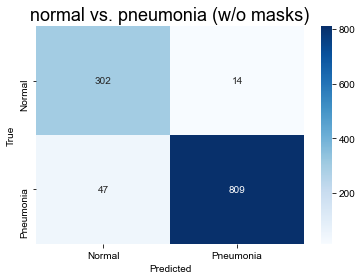

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues') #annot=True to annotate cells
sns.set(font_scale=1.5)

# labels, title and ticks
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('normal vs. pneumonia (w/o masks)')
ax.xaxis.set_ticklabels(['Normal', 'Pneumonia'])
ax.yaxis.set_ticklabels(['Normal', 'Pneumonia'])